### Cargamos paqueterías

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
random_seed = 666
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [4]:
from torchvision.datasets import KMNIST

In [5]:
import matplotlib.pyplot as plt
import numpy as np

### Visalizamos datos

In [6]:
# Cargamos los datos de entrenamiento para visualizar y obtener transformación de normalización
# root <- es el fólder donde se descargan los datos ( "./" es para que esté escondido a la vista el fólder )
trainset = KMNIST(root='./data', train=True,download=True,transform=transforms.ToTensor())

In [7]:
# Número de datos para testing
n_train = len(trainset)
n_train

60000

In [8]:
# Cargamos los datos para ploteo y realizar normalización
plotloader = torch.utils.data.DataLoader(trainset, batch_size=n_train)

In [9]:
# Función para mostrar las imágenes con las que trabajaremos
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
plotimgsiter = iter(plotloader)
images, labels = next(plotimgsiter)

In [11]:
# Las etiquetas son números del 0 al 10
labels

tensor([8, 7, 0,  ..., 0, 4, 9])

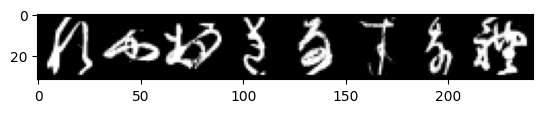

In [12]:
# Ploteamos primeras 10 imágenes
imshow(torchvision.utils.make_grid(images[0:8]))

#### (Normalización de imágenes)

In [13]:
# Paquetería para imágenes PIL (los datasets de pytoch están en este formato)
from PIL import Image

In [14]:
# Cargamos imagen
img_path = '../Art/Teporingo.jpg'
img = Image.open(img_path)

In [15]:
# Convertimos imagen PIL a arreglo de numpy (las imágenes cargadas con el DataLoader de pytorch tienen método .numpy() para esto)
img_np = np.array(img)

Text(0.5, 1.0, 'Distribución de valor de pixel')

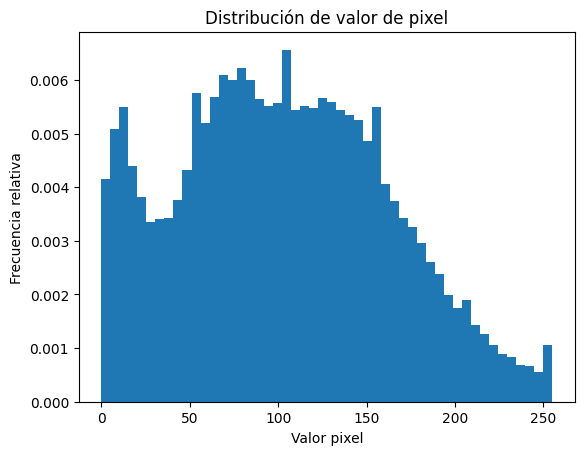

In [16]:
# Ploteamos histograma de los valores de los pixeles
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Valor pixel")
plt.ylabel("Frecuencia relativa")
plt.title("Distribución de valor de pixel")

Para las imágenes PIL los pixeles toman valores en $[0,250]$. Sin embargo al transformar a tensor pytorch cambia este dominio de valores de pixeles a $[0,1]$. 

In [17]:
# Transformamos la imagen a tensor
img_tensor = transforms.ToTensor()(img)
# Transformamos a arreglo de numpy
img_np = img_tensor.numpy()

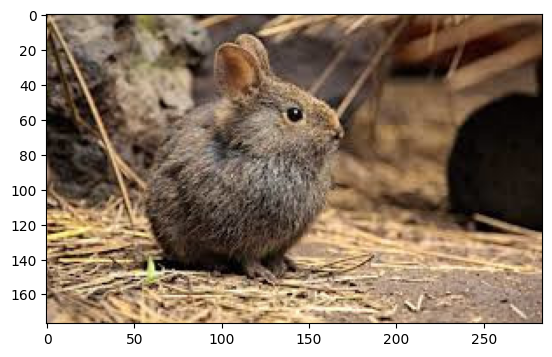

In [18]:
# Ploteamos imagen
plt.imshow(np.transpose(img_np, (1, 2, 0)))
plt.show()

Text(0.5, 1.0, 'Distribución de valor de pixel')

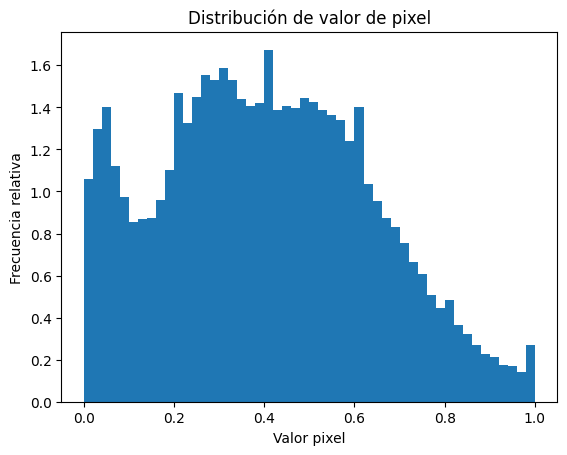

In [19]:
# Ploteamos histograma de los valores de los pixeles
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Valor pixel")
plt.ylabel("Frecuencia relativa")
plt.title("Distribución de valor de pixel")

Dependiendo del conjunto de datos tendremos distintas distribuciones sobre los pixeles de los tensores por lo que es importante normalizar restando la media y dividiendo por la desviación estándar. En el caso de la imagen del Teporingo

In [20]:
# El tensor contiene 3 dimensiones
len(img_tensor)

3

In [21]:
# Media del valor pixel promedio por imagen de prueba
# se reduce sobre la dimensión 1 y luego la dimensión 2 en el tensor
m_norm = img_tensor.mean([1,2])
m_norm

tensor([0.4916, 0.4032, 0.3184])

In [22]:
# Media del desviación estandar de valor pixel medio por imagen de prueba
# se reduce sobre la dimensión 1 y luego la dimensión 2
std_norm = img_tensor.std([1,2])
std_norm

tensor([0.2456, 0.2232, 0.1882])

Y la transformación en pytorch para normalizar queda dada por

In [23]:
img_norm_transform = transforms.Normalize(m_norm,std_norm )

In [24]:
img_tensor_normalized = img_norm_transform(img_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0016797..3.0598335].


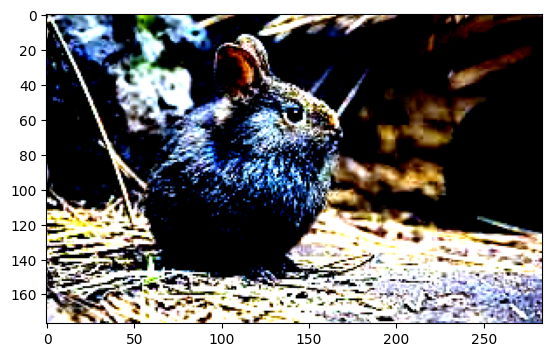

In [25]:
# Ploteamos imagen
img_np = np.array(img_tensor_normalized)
plt.imshow(np.transpose(img_np, (1, 2, 0)))
plt.show()

### Normalizamos datos

Para la base de datos de prueba KMNIST calculamos

In [26]:
KMNSIT_m_norm = torch.mean( images[0], dim=(1, 2))
KMNSIT_s_norm = torch.std( images[0], dim=(1, 2))
for i in range(1,n_train):
    KMNSIT_m_norm += torch.mean( images[i], dim=(1, 2))
    KMNSIT_s_norm += torch.std( images[i], dim=(1, 2))
KMNSIT_m_norm = KMNSIT_m_norm /n_train
KMNSIT_s_norm = KMNSIT_s_norm /n_train

In [27]:
KMNST_norm_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(KMNSIT_m_norm,KMNSIT_s_norm)])

### Cargamos datos para aprendizaje supervisado

In [28]:
# Cargamos datos de entrenamiento
trainset = KMNIST(root='./data', train=True, download=True, transform=KMNST_norm_transform)

In [29]:
# Número de datos para entrenamiento
n_train = len(trainset)
n_train

60000

In [30]:
# Partimos los datos de entrenamiento en validación y entrenamiento
trainset, valset = torch.utils.data.random_split(trainset,[40000,20000])
n_train = len(trainset)
n_val = len(valset)

In [31]:
# La función DataLoader para cargar eficientemente los datos hace uso de un "tamaño de lote" ya sea para
# los lotes en la rutina de optimización del entrenamiento o para validación cruzada cuando realizamos validación
# ó testeo.
batch_size_train = 60
batch_size_no_train = 500

In [32]:
# Loader para entrenamiento, suffle=True para rutina optimización estocástica
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,shuffle=True,num_workers=2)

In [33]:
# Loader para validación, suffle=False ya que no se entrena
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_no_train,shuffle=False,num_workers=2)

In [34]:
# Cargamos datos de prueba
testset = KMNIST(root='./data', train=False,download=True, transform=KMNST_norm_transform)

In [35]:
# Número de datos para prueb
n_test = len(testset)
n_train,n_val,n_test

(40000, 20000, 10000)

In [36]:
# Loader para prueba de la red, suffle=False ya que no se entrena
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_no_train,shuffle=False, num_workers=2)

In [37]:
# Categoria en las que se clasifica
clases = np.arange(0,10)

### Definimos el modelo de red neuronal

In [38]:
# Definimos la red neuronal mediante la clase Net
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Dos capas convolucionales en la clase
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # Input: 1, Canales: 32, Tamaño kernel: 3x3, Stride: 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # Input: 32, Canales: 64, Tamaño kernel: 3x3, Stride: 1
        # Dos pasos de dropouts para regularización en la clase
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # Dos capas fully connected en la clase
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # Se define la red neuronal desde los inputs (features) hacia los outputs (categorías de clasificación)
        x = self.conv1(x) # Capa convolucional 1
        x = F.relu(x) # Función de activación ReLU (Rectified Linear Unit)
        x = self.conv2(x) # Capa convolucional 2
        x = F.relu(x) # Función de activación ReLU (Rectified Linear Unit)
        x = F.max_pool2d(x, 2) # Función de activación maxpool
        x = self.dropout1(x) # Regularización con dropout
        x = torch.flatten(x, 1) # Aplanamos a un vector uni-dimensional
        x = self.fc1(x) # Capa completamente conectada
        x = F.relu(x) # Función de activación ReLU (Rectified Linear Unit)
        x = self.dropout2(x) # Regularización con dropout
        x = self.fc2(x) # Capa completamente conectada
        output = F.log_softmax(x, dim=1) # Logaritmo de Softmax para output en el (log) simplejo
        return output

### Elegimos una función de pérdida

In [39]:
# Función para pérdidas con verosimilitud negativa
loss_fn = torch.nn.NLLLoss()

### Inicializamos el modelo

In [40]:
# Inicializamos la red
model = NeuralNet()

In [41]:
# Celda en caso de usar GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

NeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [42]:
# Checamos que las dimensiones sean correctas y corra la red
# Generamos un tensor aleatorio equivalente a una imagen de 28x28
random_data = torch.rand((1, 1, 28, 28)).to(device)
# La evaluamos en el input aleatorio
result = model(random_data)
# Imprimimos el output 
print (result)

tensor([[-2.3194, -2.3281, -2.2052, -2.3741, -2.3427, -2.2658, -2.2699, -2.3744,
         -2.2333, -2.3282]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [43]:
# Checamos que la dimensión del output sea correcta evaluando en la función de pérdida
fake_target = torch.tensor([4]).to(device)
# Definimos la función de pérdida dada por la verosimilitud negativa
loss_prueb = loss_fn(result,fake_target) # Negative log-likelihood
# Valor de la pérdida
loss_prueb.item()

2.3426620960235596

### Elegimos rutina de optimización estocástica iterativa

In [44]:
# Urilizamos decenso estocástico del gradiente con tasa de aprendizaje γ y momento ρ
γ = 0.001
ρ = 0.9
optimizer = optim.SGD(model.parameters(), lr=γ, momentum=ρ)

### Paso de entrenamiento

In [45]:
# Paso de entrenamiento
# epoch <- número del paso
# tb_writer <- donde guardamos toda la información para reportar sobre el entrenamiento
def train_step(epoch, tb_writer):
    running_stoch_loss = 0.0 # Pérdida acumulada sobre stochastic batches
    last_stoch_loss = 0.0 # Última pérdida calculada
    # Enumeramos el stochastic batch para reportar sobre entrenamiento
    for i, data in enumerate(trainloader):
        # Separamos datos en input y etiqueta
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Los gradientes se acumulan en pytorch, no se sobre-escriben
        # por lo que hay que hacerlos cero antes de actualizarlos en el entrenamiento
        # Se debe correr antes de loss.backward()
        optimizer.zero_grad()
        # Ajustes en el stochastic batch
        outputs = model(inputs)
        # Calculamos la pérdida
        loss = loss_fn(outputs, labels)
        # Calculamos gradientes con backward propagation
        loss.backward()
        # Hacemos el paso de optimización estocástica en el lote
        optimizer.step()
        # Actualizamos la pérdida acumulada
        running_stoch_loss += loss.item()
        # Reportamos cada 1000 iteraciones
        if i % 100 == 99:
            last_stoch_loss = running_stoch_loss / 100 # pérdida por lote
            print('  Lote {} tuvo pérdida: {}'.format(i + 1, last_stoch_loss))
            tb_x = epoch * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_stoch_loss, tb_x)
            running_stoch_loss = 0.0
    return last_stoch_loss

In [46]:
# PyTorch TensorBoard support
from tensorboardX import SummaryWriter
from datetime import datetime

In [47]:
# Inicializamos entrebamiento
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/KMNIST_trainer_{}'.format(timestamp))
epoch_number = 0

In [48]:
# Entrenamiento
EPOCHS = 10
# Número grande para mejor pérdida en validación
best_loss_val = 1_000_000.
# Loop de entrenamiento
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Activamos trackeo de gradientes
    model.train(True)
    # Paso de entrenamiento para inicializar pérdida media
    avg_loss = train_step(epoch, writer)
    # Pérdida en datos de validación a través del loop de entrenamiento
    running_val_loss = 0.0
    # Activamos modo de evaluación para reportar ajuste sobre datos de validación sin alterar el entrenamiento,
    # en particular desactiva dropout y usa valores poblacionales para normlizar los lotes de data
    model.eval()
    # Desactivamos computo de gradientes, lo que reduce consumo de memoria
    with torch.no_grad():
        for i, valid_data in enumerate(validloader):
            # Separamos datos de validación en input y etiqueta
            valid_inputs, valid_labels = valid_data
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            # Ajuste aprendido sobre los datos de validación
            valid_outputs = model(valid_inputs)
            # Calculamos la pérdida sobre los datos de validación
            val_loss = loss_fn(valid_outputs, valid_labels)
            # Actualizamos la pérdida acumulada
            running_val_loss += val_loss
    avg_val_loss = running_val_loss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_val_loss))
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_val_loss },
                    epoch_number + 1)
    writer.flush()
    # Track best performance, and save the model's state
    if avg_val_loss < best_loss_val:
        best_loss_val = avg_val_loss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    epoch_number += 1

EPOCH 1:
  Lote 100 tuvo pérdida: 2.0783462631702423
  Lote 200 tuvo pérdida: 1.1995851129293442
  Lote 300 tuvo pérdida: 0.8711953473091125
  Lote 400 tuvo pérdida: 0.7607635846734047
  Lote 500 tuvo pérdida: 0.6839987570047379
  Lote 600 tuvo pérdida: 0.6501540404558181
LOSS train 0.6501540404558181 valid 0.4316082000732422
EPOCH 2:
  Lote 100 tuvo pérdida: 0.5870064562559127
  Lote 200 tuvo pérdida: 0.5662183071672916
  Lote 300 tuvo pérdida: 0.5345950788259506
  Lote 400 tuvo pérdida: 0.5245524623990059
  Lote 500 tuvo pérdida: 0.5141550202667713
  Lote 600 tuvo pérdida: 0.5000001728534699
LOSS train 0.5000001728534699 valid 0.33930596709251404
EPOCH 3:
  Lote 100 tuvo pérdida: 0.46842766672372815
  Lote 200 tuvo pérdida: 0.47445252746343614
  Lote 300 tuvo pérdida: 0.45135911241173743
  Lote 400 tuvo pérdida: 0.43738163247704503
  Lote 500 tuvo pérdida: 0.41703794166445735
  Lote 600 tuvo pérdida: 0.44238901883363724
LOSS train 0.44238901883363724 valid 0.2633512616157532
EPOCH 4:

In [50]:
pytorch tensorboard --logdir=runs

SyntaxError: invalid syntax (730293260.py, line 1)

In [ ]:
model_conv.layer1[0].conv1.weight